In [1]:
%autosave 30
%matplotlib inline
# for tips: https://www.kaggle.com/prakharprasad/facerecognition-facenet-cnnclassifier

Autosaving every 30 seconds


# Basics

**FaceNet**
* FaceNet is a face recognition system that was described by Florian Schroff, et al. at Google in their 2015 paper titled “FaceNet: A Unified Embedding for Face Recognition and Clustering.”
* It is a system that, given a picture of a face, will extract high-quality features from the face and predict a 128 element vector representation these features, called a face embedding.

## Import liberaries

In [2]:
import os
import sys
import random
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Python Imaging Library (PIL) by Fredrik Lundh
from PIL import Image  
from keras.models import load_model


# For classification of different faces, SVC
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.metrics import accuracy_score

from platform import python_version
print(f"python version: {python_version()}")

python version: 3.7.12


## MCTNN
* Multi-task Cascaded Convolutional Networks (MTCNN) is a framework developed by David Sandberg as a solution for both face detection and face alignment. 
* The process consists of three stages of convolutional networks that are able to recognize faces and landmark location such as eyes, nose, and mouth.

In [4]:
# create the mtcnn detector using default weights
# Multi-task Cascaded Convolutional Networks (MTCNN)
from mtcnn.mtcnn import MTCNN
detector = MTCNN()
#print(mtcnn.__version__)

## Saved Facenet Model

In [5]:
## Get the general path for saved model
path_saved_model=os.environ.get('DirForSavedModel')+'/face_recognisition/'
facenet_model=load_model(path_saved_model+'facenet_keras.h5')

print(f"Input: {facenet_model.inputs}")
print(f"Output: {facenet_model.outputs}")

Input: [<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
Output: [<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


# Download Dataset

## Download Kaggle dataset
- this does not work, since the API I use is meant for downloading competition dataset, and this dataset is owned privately by someone called dansbecker.

In [6]:
#sys.path.append(os.environ.get('DirForPoolScripts'))
#from download_kaggle_data import upload_kaggle_dataset

In [7]:
#base_dir = os.environ.get('DirForSavedModel')
#dataset_name = 'dansbecker/5-celebrity-faces-dataset'
#facenet_model = 'facenet-keras'
#upload_kaggle_dataset(base_dir_name=base_dir, kaggle_dataset_name=facenet_model)

# Data Preprocessing

## Define directory structure

In [8]:
base_dir = os.environ.get('DirForImages')+'/5-celebrity-faces-dataset/'

sub_dir_name = [dirs for dirs in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, dirs))]
print(f"sub_directories are {sub_dir_name}")

base_dir_train  = os.path.join(base_dir, sub_dir_name[0]+'/')
base_dir_data   = os.path.join(base_dir, sub_dir_name[1]+'/')
base_dir_val    = os.path.join(base_dir, sub_dir_name[2]+'/')

sub_sub_dir = os.listdir(os.path.join(base_dir,base_dir_train))

base_dir_ben     = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'ben' in fn])+'/')
base_dir_madonna = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'madonna' in fn])+'/')
base_dir_elton   = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'elton' in fn])+'/')
base_dir_mindy   = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'mindy' in fn])+'/')
base_dir_jerry   = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'jerry' in fn])+'/')
base_dir_michelle   = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'michelle' in fn])+'/')
base_dir_angelina   = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'angelina' in fn])+'/')
base_dir_jackie   = os.path.join(base_dir_train, ' '.join([str(fn) for fn in sub_sub_dir if 'jackie' in fn])+'/')

sub_directories are ['train', 'data', 'val']


## Draw frequency plot

In [9]:
def draw_name_frequency_plot(directory):
    
    labels = [subdir.replace("_", " ").title() for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory,subdir))]
    label_count = [len(os.listdir(os.path.join(directory, subdir))) for subdir in os.listdir(directory) if os.path.isdir(os.path.join(directory,subdir)) ]
            
    c = ['green', 'yellow', 'cyan', 'gray', 'orange','olive','sandybrown','plum']
    plt.rcParams["figure.figsize"] = (16,5)
    plt.bar(labels, label_count, color=c)
    plt.ylabel('count', fontsize=20)
    plt.xticks(fontsize= 14)
    plt.yticks(fontsize= 14)
    plt.grid(True, linewidth= 1, linestyle="--")
    plt.show()  

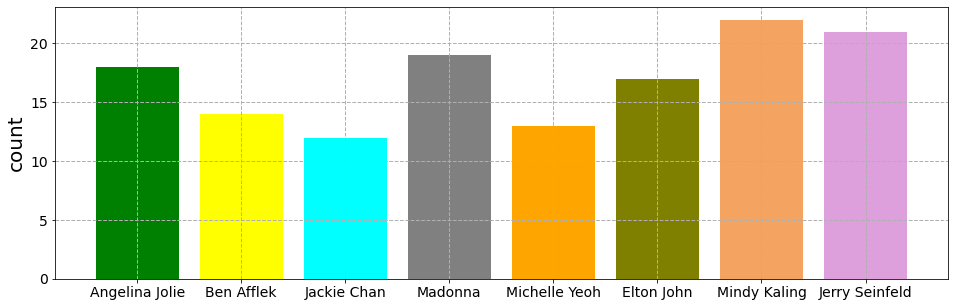

In [10]:
draw_name_frequency_plot(base_dir_train)

## Extract facial features
´detector=MTCNN()´
* The detector returns a list of JSON objects. Each JSON object contains three main keys: 'box', 'confidence' and 'keypoints':
    - The bounding box is formatted as [x, y, width, height] under the key 'box'.
    - The confidence is the probability for a bounding box to be matching a face.
    - The keypoints are formatted into a JSON object with the keys 'left_eye', 'right_eye', 'nose', 'mouth_left', 'mouth_right'. Each keypoint is identified by a pixel position (x, y).

In [11]:
def draw_face_boundaries(image, feature_coordinate):
    filename = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    bounding_box = feature_coordinate[0]['box']
    keypoints = feature_coordinate[0]['keypoints']
    cv2.rectangle(filename,
                  (bounding_box[0], bounding_box[1]),
                  (bounding_box[0]+bounding_box[2], bounding_box[1] + bounding_box[3]),
                  (0,155,255),
                  2)
    cv2.circle(filename,(keypoints['left_eye']),   2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['right_eye']),  2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['nose']),       2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['mouth_left']), 2, (0,155,255), 2)
    cv2.circle(filename,(keypoints['mouth_right']),2, (0,155,255), 2)
    cv2.imwrite(image, cv2.cvtColor(filename, cv2.COLOR_RGB2BGR))
    plt.imshow(filename)

In [12]:
def extract_face(filename,required_size=(160, 160), print_features=False, show_features=False): 
    
    # pre-processing on file image
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)

    face_coordinates = detector.detect_faces(pixels)
    
    if show_features:
        draw_face_boundaries(filename, face_coordinates)
    if print_features:
        print(f"> Extracted features: \n {face_coordinates}")

    x1, y1, width, height = face_coordinates[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = pixels[y1:y2, x1:x2]
    
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    
    return face_array

2021-11-01 14:19:54.069068: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


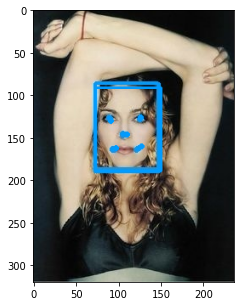

In [13]:
# load the photo and extract the face
pixels = extract_face(base_dir_madonna + os.listdir(base_dir_madonna)[15],  show_features=True)
#plt.imshow(pixels)

In [14]:
def extract_all_faces(directory, show_points=False, show_print=False):
    nrows = 4
    ncols = round(len(os.listdir(directory)) / nrows) + 1
    
    for count, filename in enumerate(os.listdir(directory)):
        path = directory + "/" + filename
        face = extract_face(path, show_features=show_points, print_features=show_print)
        plt.subplot(nrows, ncols, count+1)
        plt.axis('off')
        plt.imshow(face)
    plt.show()

In [ ]:
extract_all_faces(directory=base_dir_jackie, show_points=True)

## Prepare dataset

In [15]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
    X, y = [],[] 

    for subdir in os.listdir(directory):
        path = directory + subdir + '/'

        # skip directories
        if not os.path.isdir(path):
            continue

        faces = [extract_face(path+subpath) for subpath in os.listdir(path)]        
        labels = [subdir for _ in range(len(faces))]
        
        print(f'>loaded {len(faces)} examples for class: {subdir}')
        
        X.extend(faces)
        y.extend(labels)
        
    return np.asarray(X), np.asarray(y)

In [16]:
# load train dataset
trainX, trainy = load_dataset(base_dir_train)
testX,   testy = load_dataset(base_dir_val)
print(f"train=> X.shape: {trainX.shape}, y.shape: {trainy.shape}")
print(f"test=> X.shape: {testX.shape}, y.shape: {testy.shape}")

>loaded 18 examples for class: angelina_jolie
>loaded 14 examples for class: ben_afflek
>loaded 12 examples for class: jackie_chan
>loaded 19 examples for class: madonna
>loaded 13 examples for class: michelle_yeoh
>loaded 17 examples for class: elton_john
>loaded 22 examples for class: mindy_kaling
>loaded 21 examples for class: jerry_seinfeld
>loaded 5 examples for class: angelina_jolie
>loaded 5 examples for class: ben_afflek
>loaded 6 examples for class: michelle _yeoh
>loaded 5 examples for class: jackie_chan
>loaded 5 examples for class: madonna
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: jerry_seinfeld
train=> X.shape: (136, 160, 160, 3), y.shape: (136,)
test=> X.shape: (41, 160, 160, 3), y.shape: (41,)


# Modelling

## Face Embedding via Facenet

In [17]:
def get_128vectorEmbedding_singleImage(model, face_pixels):
    # scale pixel values
    face_pixels = face_pixels.astype('float32')
    
    # normalize pixel values across channels
    face_pixels_normalized = (face_pixels - face_pixels.mean()) / face_pixels.std()
    
    # transform face into one sample
    samples = np.expand_dims(face_pixels_normalized, axis=0)
    
    # make prediction to get embedding
    yhat = model.predict(samples) # returns ndarrary:(1,128)
    
    return yhat[0]

In [18]:
# get the face embedding for whole dataset, train/text
def get_embedding_dataset(model, train_X, test_X):
    
    embTrain_X = [get_128vectorEmbedding_singleImage(model, face_pixels) for face_pixels in train_X]
    embTest_X  = [get_128vectorEmbedding_singleImage(model, face_pixels) for face_pixels in test_X]
    
    print(f'embTrain_X shape: {np.asarray(embTrain_X).shape}, embText_X shape: {np.asarray(embTest_X).shape}')
    
    return np.asarray(embTrain_X), np.asarray(embTest_X)

In [19]:
embTrain_X, embTest_X = get_embedding_dataset(model=facenet_model, train_X=trainX, test_X=testX)

embTrain_X shape: (136, 128), embText_X shape: (41, 128)


## SVM Classifier

In [20]:
def normalize_vectors(vectors):
    """ normalize input vectors """ 
    normalizer = Normalizer(norm='l2')
    vectors = normalizer.transform(vectors)

    return vectors

In [21]:
def labels_encoder(labels):
    """provide one hot encoding of incoming labels"""
    out_encoder = LabelEncoder()
    out_encoder.fit(labels)
    labels = out_encoder.transform(labels)
    return out_encoder, labels

In [22]:
def svm_classifier(train_x_embedding, train_y, test_x_embedding, test_y):

    # normalize input vectors
    train_x_norm_embedding   = normalize_vectors(train_x_embedding)
    test_x_norm_embedding    = normalize_vectors(test_x_embedding)

    # label encode targets 
    out_encoder, train_y_class = labels_encoder(train_y)
    out_encoder, test_y_class  = labels_encoder(test_y)

    # fit model
    model       = SVC(kernel='linear', probability=True)
    model.fit(train_x_norm_embedding, train_y_class)
    
    yhat_train  = model.predict(train_x_norm_embedding)
    yhat_test   = model.predict(test_x_norm_embedding)
    
    score_train = accuracy_score(train_y_class, yhat_train)
    score_test  = accuracy_score(test_y_class, yhat_test)
    print(f'Accuracy: train={score_train*100}, test={score_test*100}')
    
    return model

In [23]:
svm_model= svm_classifier(embTrain_X, trainy, embTest_X, testy)

Accuracy: train=100.0, test=97.5609756097561


## Save SVM model

In [24]:
## save the model
try:
    import dill as pickle
except ImportError:
    import pickle
with open(path_saved_model+'svm_classifie_8_celebraties.pkl','wb') as file_pi:
    pickle.dump(svm_model, file_pi)

In [ ]:
# load the model
#model_test = pickle.load(open(path_saved_model+'svm_classifie_5_celebraties.pkl', "rb"))

# use model to predict
#y_pred = model.predict(X_input)

In [ ]:
#test_x_norm_embedding, test_y_class, label_encoder, svm_model= svm_classifier(embTrain_X, trainy, embTest_X, testy)

# Testing

## Test random testimages

In [33]:
def random_testing_test_data(test_data, test_label, embedding_model, classification_model) :
    # test model on a random example from the test dataset
    selection          = random.choice([i for i in range(test_data.shape[0])])

    random_face_pixels = get_128vectorEmbedding_singleImage(embedding_model, test_data[selection])
    random_face_pixels = np.expand_dims(random_face_pixels, axis=0)
    random_face_emb    = normalize_vectors(random_face_pixels)

    label_encoder, test_y_class  = labels_encoder(test_label)
    random_face_class            = test_y_class[selection]
    random_face_name             = label_encoder.inverse_transform([random_face_class])

    # prediction for the face
    yhat_class = classification_model.predict(random_face_emb)
    yhat_prob  = classification_model.predict_proba(random_face_emb)

    # get name
    class_index       = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    predict_names     = label_encoder.inverse_transform(yhat_class)
    print(f'Predicted: {predict_names[0].replace("_"," ").title()} confidence:({round(class_probability,2)})')
    print(f'Expected: {random_face_name[0].replace("_"," ").title()}')

    # ploting
    plt.imshow(test_data[selection])
    title = f'{predict_names[0].replace("_"," ").title()} ({round(class_probability,2)})'
    plt.title(title)
    plt.show()

Predicted: Madonna confidence:(76.84)
Expected: Madonna


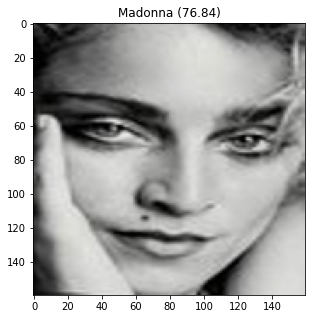

In [46]:
random_testing_test_data(testX, testy, facenet_model, svm_model)

## Externally uploaded face

In [50]:
# load the model
path_saved_model=os.environ.get('DirForSavedModel')+'/face_recognisition/'
svm_model = pickle.load(open(path_saved_model+'svm_classifie_8_celebraties.pkl', "rb"))
facenet_model=load_model(path_saved_model+'facenet_keras.h5')

In [85]:
def extract_labels(directory):
    y = []
    for subdir in os.listdir(directory):
        path = directory + subdir + '/'
        if not os.path.isdir(path):
            continue
        range_dir = [subpath for subpath in os.listdir(path)]
        labels = [subdir for _ in range(len(range_dir))]
        y.extend(labels)
    return np.asarray(y)

def load_labels():
    base_dir = os.environ.get('DirForImages')+'/5-celebrity-faces-dataset/'
    dataset_path = os.path.join(base_dir, 'train/')
    labels = extract_labels(dataset_path)
    return labels

labels = load_labels()

In [81]:
def externaly_uploaded_face(image, test_label, embedding_model, classifiation_model, threshold=80):
    image_pixels = extract_face(image, show_features=False)
    emb_image    = get_128vectorEmbedding_singleImage(embedding_model, image_pixels)
    print(emb_image)

    # prediction for the face
    samples_image = np.expand_dims(emb_image, axis=0)
    yhat_class    = classifiation_model.predict(samples_image)
    yhat_prob     = classifiation_model.predict_proba(samples_image)

    # setup encoder for test images    
    label_encoder, test_y_class  = labels_encoder(test_label)

    # get name
    class_index       = yhat_class[0]
    class_probability = yhat_prob[0,class_index] * 100
    
    if class_probability >= threshold:
        predicted_name = label_encoder.inverse_transform(yhat_class)[0]
    else:
        predicted_name = 'Unknown'
    
    plt.imshow(image_pixels)
    title = f'{predicted_name.replace("_"," ").title()} ({round(class_probability,2)})'
    plt.title(title)
    print(f'Predicted: {predicted_name.replace("_"," ").title()} confidence:({round(class_probability,2)})')
    plt.show()

In [87]:
os.listdir(base_dir_data)

['jennifer.jpeg',
 'madonna.jpeg',
 'download (6).jpeg',
 'ben-affleck-01.jpeg',
 'images (3).jpeg',
 'angelina-jolie-ist-jetzt-bei.jpeg',
 'ben-affleck-03.jpeg',
 'ben-affleck.jpeg',
 'madonna_eyeclosed.jpeg',
 'mindy.jpeg']

[-1.8995187   0.7141986  -0.46119213  0.41575977 -1.3591689   0.32816872
  0.33597165  0.4836739   0.40100423 -0.01879629 -0.58370554  1.1615986
 -0.1539142   0.939749   -0.65510404 -0.33521652 -1.1422015   1.0776527
  1.5722737   0.8054111   1.1939187  -0.44875845  0.29087162 -1.1956307
 -0.40326563  0.8726763  -2.9022882  -0.52775484  0.22329064 -0.8981285
 -0.62197375  0.08688001 -0.9765629   0.23981687  1.5995572  -0.17902836
 -0.03343893 -1.6073626   0.81026894 -1.4915711  -0.5013951   1.5240527
 -0.75874937 -0.0917756  -0.2271131   1.0366545  -1.6329039   1.1215875
 -0.29128253  2.2484393   0.5508685   1.193354   -0.12495487  0.49428454
 -0.28593376 -0.47356486 -1.0197414  -0.13602112  0.83968586 -0.44867066
  0.09351134 -0.04016526  0.7244619  -1.7693269   0.4620439   0.05102908
  0.43205702  0.05657918  0.83222824  0.40052012  0.9860238   0.26861578
 -0.5603981   0.45552897 -1.0086385  -1.0503281   0.69542146 -0.70422304
 -0.24558741  0.08698435  0.7759475  -1.0851401  -0.76099

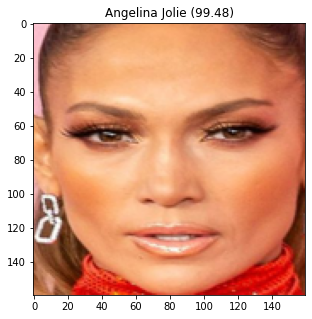

In [89]:
image= os.listdir(base_dir_data)[0]
image_path=os.path.join(base_dir_data, image)
externaly_uploaded_face(image_path, labels, facenet_model, svm_model, threshold=80)